In [35]:
import sys
import os
from pathlib import Path
# allow it to find simdrive module
fsimpath=str(Path(os.getcwd()).parents[0])
if fsimpath not in sys.path:
    sys.path.append(fsimpath)
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import ChainMap
from scipy.integrate import cumtrapz, trapz
import re
import importlib
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
# local modules
from fastsim import simdrivehot, simdrive, vehicle, cycle, params
# importlib.reload(simdrive)
# importlib.reload(cycle)

# IMPORTANT TASKS
## General
Make sure temp is initalized for each sim_drive_walk  
Make sure fc efficiency impact is accounted for  
Make sure heater affects engine temp and maybe aux load  
Make sure A/C affects aux load  
Cabin thermal model before tuning?

## Tuning
### Parameters
radiator convection coeff.  
idle convection coeff.  
heater something  
thermal mass = f(displacement)?  
diameter = f(displacement)?

### Objectives
fuel consumption  
temperature fit  
eng. temperature derivative fit  
cabin temperature fit  
cabin temperature derivative fit



In [10]:
# load the vehicle test data
def load_test_data():
    print('Loading test data.')
    test_data_path = 'C:\\Users\\cbaker2\\Documents\\TestData\\FordFusionTestData\\'
    t0 = time.time()
    datadirs = [test_data_path + 'udds_tests\\',
                test_data_path + 'us06_tests\\']
    tests = [[test for test in os.listdir(f) if 
        'csv' in test] for f in datadirs]

    dflist = [{j: pd.read_csv(i+j)
            for j in tests[datadirs.index(i)]} for i in datadirs]
    print('Elapsed time to read data files: {:.3e} s'.format(time.time() - t0))
    dfdict0 = dict(ChainMap(*reversed(dflist)))
    dfdict1 = {}

    for key in dfdict0.keys():
        repkey = key[9:].replace('.xlsx', '').replace(' ', '').replace('_', ' ')
        #     cyclekey = re.match('\S+(?=x\d)', repkey)[0] # grab cycle name without repetition suffix
        # grab cycle name with repetition suffix
        cyclekey = re.match('\S+', repkey)[0]
        tempkey = re.search('\d{1,2}F', repkey)[0]
        startkey = re.search('(?<=_)(c|h)s', key)[0]
        dfdict1[cyclekey + ' ' + tempkey + ' ' + startkey] = dfdict0[key]
    del dfdict0
    times = np.arange(0, 1500, 250)

    # dict for results dataframes
    resdfdict = {}
    dfdict = {}

    cs_keys = [key for key in dfdict1.keys() if re.search('\scs$', key)]

    for k in cs_keys:
        # print(k)

        # Remove rows with wacky time
        steps = dfdict1[k]['DAQ_Time[s]'].diff()
        timejumps = np.where(steps < 0)[0]
        timejump = timejumps[-1]
        dfdict[k] = dfdict1[k].drop(np.arange(timejump), axis=0)
        dfdict[k].index -= dfdict[k].index.min()

        # Remove extra columns
        dfdict[k].insert(int(np.where(dfdict[k].columns == 'Dyno_Spd[mph]')[
                        0][0]), 'Dyno_Spd[mps]', dfdict[k]['Dyno_Spd[mph]'] * 0.44704)

        dfdict[k]['Tractive_Power[W]'] = dfdict[k]['Dyno_TractiveForce[N]'] * \
            dfdict[k]['Dyno_Spd[mps]']
        dfdict[k]['PosTractive_Power[W]'] = dfdict[k]['Tractive_Power[W]']
        # negindices = np.where(dfdict[k]['Tractive_Power[W]'] < 0)[0]
        negindices = dfdict[k]['Tractive_Power[W]'] < 0
        dfdict[k].loc[negindices, 'PosTractive_Power[W]'] = 0

        dfdict[k]['Kinetic_Power_Density[W/kg]'] = dfdict[k]['Dyno_Spd[mps]'] * dfdict[k]['Dyno_Spd[mps]'].diff() \
            / dfdict[k]['DAQ_Time[s]'].diff()
        dfdict[k]['Kinetic_Power_Density[W/kg]'].fillna(0, inplace=True)

        dfdict[k]['PosKinetic_Power_Density[W/kg]'] = dfdict[k]['Kinetic_Power_Density[W/kg]']
        dfdict[k].loc[dfdict[k]['Kinetic_Power_Density[W/kg]']
                    <= 0, 'PosKinetic_Power_Density[W/kg]'] = 0

        dfdict[k]['PosTractive_Energy[J]'] = np.concatenate((np.array([0]), cumtrapz(
            dfdict[k]['PosTractive_Power[W]'], x=dfdict[k]['DAQ_Time[s]'])), axis=0)
        dfdict[k]['Distance[m]'] = np.concatenate((np.array([0]), cumtrapz(
            dfdict[k]['Dyno_Spd[mps]'], x=dfdict[k]['DAQ_Time[s]'])), axis=0)

        dfdict[k]['PosKinetic_Energy_Density[J/kg]'] = np.concatenate((np.array([0]),
                                                                    cumtrapz(dfdict[k]['PosKinetic_Power_Density[W/kg]'].values,
                                                                                x=dfdict[k]['DAQ_Time[s]'].values)), axis=0)


        dfdict[k].index.set_names('time_step', inplace=True)

        # bring temperature into data frame from filenames
        dfdict[k]['Temp_Amb[C]'] = round(
            (int(re.search('\d{1,2}(?=F)', k)[0]) - 32) * 5 / 9, 1)

        # compute deltaT at times
        indices = [np.where(dfdict[k]['DAQ_Time[s]'] >= t)[0][0] for t in times]

        # resdfdict[k].drop(axis=0, index=0, inplace=True) # probably want this initial row
        dfdict[k].set_index([dfdict[k].index, 'Temp_Amb[C]'], inplace=True)

    keys = list(dfdict.keys())
    del dfdict1

    df = pd.concat(dfdict, sort=False)
    df.index.set_names('filename', level=0, inplace=True)
    df = df.reorder_levels(['filename', 'Temp_Amb[C]', 'time_step'])
    cols0 = list(df.columns.values)
    # reorder columns in terms of independent and dependent variables
    cols = [cols0[0]] + cols0[-3:] + cols0[2:-3]
    df = df[cols]
    df['Powertrain Efficiency'] = df['Dyno_Power_Calc[kW]'] / df['Fuel_Power_Calc[kW]']
    df.drop(columns=[col for col in df.columns if re.search(
        'Unnamed', col)], inplace=True)
    
    return df


In [19]:
df = load_test_data()
idx = pd.IndexSlice # used to slice multi index 

cyc_name = 'us06x4 0F cs'

In [23]:
t0 = time.time()
test_time_steps = df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values
test_te_amb = df.loc[idx[cyc_name, :, :], 'Cell_Temp[C]'].values

cycSecs = np.arange(0, round(test_time_steps[-1], 0))
cycMps = np.interp(cycSecs, 
    test_time_steps, 
    df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values)

cyc = cycle.Cycle(cyc_dict={'cycSecs':cycSecs, 'cycMps':cycMps})
cyc_jit = cyc.get_numba_cyc()
print("Elapsed time to create cycle: {:.2e} s".format(time.time() - t0))

Elapsed time to create cycle: 3.59e-02 s


In [24]:
t0 = time.time()
veh = vehicle.Vehicle(veh_file=Path('../vehdb/2012 Ford Fusion.csv'))
veh_jit = veh.get_numba_veh()
print(time.time() - t0)

0.04986715316772461


In [54]:
t0 = time.time()
sim_drive = simdrivehot.SimDriveHotJit(cyc_jit, veh_jit, 
    teAmbDegC = np.interp(cycSecs, test_time_steps, test_time_steps),
      teFcInitDegC=df.loc[idx[cyc_name, :, 0], 'CylinderHeadTempC'][0])   
sim_drive.sim_drive()
print(f'Elapsed time: {time.time() - t0:.2e} s')

Elapsed time: 1.10e-02 s


### Results

Text(0, 0.5, 'Fuel Converter Temperature [$^\\circ$C]')

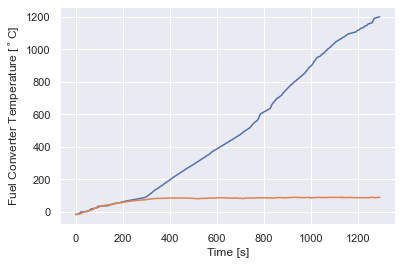

In [55]:
plt.plot(cyc.cycSecs, sim_drive.teFcDegC)
plt.plot(test_time_steps, df.loc[idx[cyc_name, :, :], 'CylinderHeadTempC'])
plt.xlabel('Time [s]')
plt.ylabel('Fuel Converter Temperature [$^\circ$C]')

Text(0, 0.5, 'Speed Achieved [mps]')

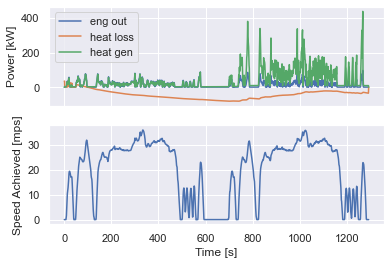

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(cyc.cycSecs, sim_drive.fcKwOutAch, label='eng out')
ax1.plot(cyc.cycSecs, sim_drive.fcConvToAmbKw, label='heat loss')
ax1.plot(cyc.cycSecs, sim_drive.fcHeatGenKw, label='heat gen')
ax1.set_ylabel('Power [kW]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed Achieved [mps]')